In [1]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

import torch
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, dense_mincut_pool
from torch_geometric.utils import to_dense_adj

from dataset import load_pyg_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm import trange, tqdm

In [2]:
from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

from sklearn.utils.fixes import lobpcg
from sklearn.utils import check_random_state
from sklearn.utils import check_symmetric, check_array
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.cluster._kmeans import k_means
from sklearn.metrics.pairwise import pairwise_kernels
import sklearn.metrics.pairwise as kernels

import matplotlib.pyplot as plt


In [3]:
# pooling = 'mincut' #(options: diffpool, mincut)
dataset_name = 'Wisconsin'

# #Pooling selector
# pooling_selector = {
#     'diffpool': dense_diff_pool,
#     'mincut': dense_mincut_pool
# }

In [4]:
data = load_pyg_dataset(
    data_name=dataset_name,
    device=device
)
num_clusters = data.y.max().tolist()+1
data.adj = to_dense_adj(data.edge_index)

The obtained data Wisconsin has 251 nodes, 515 edges, 1703 features, 5 labels, 


In [5]:
def create_affinity_matrix(x, adj, metric='rbf', kernel_params=None):
    """metric=None uses just the adjacency matrix"""
    adj = np.maximum(adj, adj.T)
    adj = np.maximum(adj, np.eye(adj.shape[0]))
    if metric is None:
        return adj
    return pairwise_kernels(x, metric=metric, **kernel_params) * adj

In [45]:
def spectral_clustering(affinity, *, p1=0.00, p2=0.10, n_clusters=8, n_init=10, verbose=False):

    random_state = check_random_state(None)
#     n_components = n_clusters if n_components is None else n_components

    # The first eigenvector is constant only for fully connected graphs
    # and should be kept for spectral clustering (drop_first = False)
    # See spectral_embedding documentation.
#     maps = spectral_embedding(affinity, front=front, n_components=n_components,
#                               eigen_solver=eigen_solver,
#                               random_state=random_state,
#                               eigen_tol=eigen_tol, drop_first=False)

    
    n = affinity.shape[0]
    laplacian, dd = csgraph_laplacian(sparse.coo_matrix(affinity), normed=True,
                                      return_diag=True)
    
    evalues, evectors = eigsh(laplacian, k=n-1)
#     print(evectors)
    
    k1 = int(n * p1)
    k2 = int(n * p2)
    maps = evectors[:, k1:k2]
    
    if verbose:
        print(f'Computing label assignment using {assign_labels}')

#     if assign_labels == 'kmeans':
    _, labels, _ = k_means(maps, n_clusters, random_state=random_state,
                           n_init=n_init, verbose=verbose)
#     else:
#         labels = discretize(maps, random_state=random_state)

    return labels


In [47]:
def test(p1, p2, metric='rbf', kernel_params=None, verbose=False, adj_np=None):
    if adj_np is None:
        adj_np = create_affinity_matrix(data.x.cpu().numpy(), data.adj[0].cpu().numpy(), 
                                        metric=metric, kernel_params=kernel_params)
    pred_node_label = spectral_clustering(adj_np, p1=p1, p2=p2, n_clusters=num_clusters)
#     else:
#         from sklearn.cluster import SpectralClustering
#         cluster = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', eigen_solver='amg')
#         cluster.fit(adj_np)
#         pred_node_label = cluster.labels_
    
    truth_node_labels = data.y.cpu().numpy()
    
    if verbose:
        bins = np.arange(num_clusters + 1) - 0.5
        plt.hist(pred_node_label, bins=bins)
        print(pred_node_label.sum())
        plt.show()
        plt.hist(truth_node_labels, bins=bins)
        plt.show()
        
    nmi = normalized_mutual_info_score(truth_node_labels.flatten(), pred_node_label.flatten())
    return nmi

def multitest(n_runs=40, **kwargs):
    scores = []
    for it in trange(n_runs):
        val = test(**kwargs)
        scores.append(val)

    return np.mean(scores), np.std(scores)

In [48]:
multitest(100, p1=0.0, p2=0.1, metric='rbf', kernel_params={'gamma': 0.001})

100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


(0.05171197111696214, 0.018478562387269467)

In [53]:
p1s = np.linspace(0., 1., 10, endpoint=False)

vals = []
stds = []

adj_np = create_affinity_matrix(data.x.cpu().numpy(), data.adj[0].cpu().numpy(), 
                                        metric='rbf', kernel_params={'gamma': 0.001})

for p1 in (p1s):
    p2 = p1 + 0.1
    val, std = multitest(1000, p1=p1, p2=p2, adj_np=adj_np)
    vals.append(val)
    stds.append(std)

100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


In [54]:
vals = np.array(vals)
stds = np.array(stds)

Text(0, 0.5, 'NMI score')

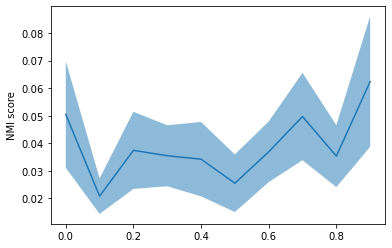

In [58]:
plt.plot(p1s, vals)
plt.fill_between(p1s, vals + stds, vals - stds, alpha=0.5)
plt.ylabel('NMI score')
plt.xlabel('')